# Differentiated Bertrand Competition

A simple model of ***differentiated*** Bertrand competition (i.e. it behaves like a Cournot model, but firms are choosing prices, not quantities).

This notebook is only partially finished (for pedagogical reasons). 

**Note:** This is rather different from the ***pure Bertrand*** model. In that model, products are ***perfect substitutes*** to consumers, so they simply choose the cheapest alternative. As we shall see, the differentiated Bertrand model has quite a bit of taste heterogeneity, implying that there is no discontinuity at the minimum price. 

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.optimize import minimize, fsolve

# Model 

Firms maximize profits given by 
$$ \pi(p_i, p_j) = M s(p_i,p_j)(p_i - c), $$ 
where $c$ are symmetric marginal cost, $M$ is the market size (turns out not to matter), and $(p_i,p_j)$ are the own and competitor prices, and where the market share function, $s(\cdot,\cdot)$, is given by 

$$ s_1(p_1,p_2) = \frac{\exp(\gamma_1 - \delta_1 p_1)}{1 + \exp(\gamma_1 - \delta_1 p_1) + \exp(\gamma_2 - \delta_2 p_2)}. $$

*Why doesn't the market size matter?* Because whether firms maximize $\pi_i (p_i,p_j)$ or $ 10,000 \pi_i (p_i,p_j)$ makes no difference: the maximizing value of $p_i$ is the same. Hence, we can just treat the problem *as if* $M := 1$. It is as if we are measuring profits *per consumer* as opposed to just total profits. 

## Technical details (for the curious)

### Where does the choice probability formula come from? 
This comes from a model where the consumer gets indirect utility 
$$ u_{ij} = 1 - \delta_j p_j + \varepsilon_{ij}$$ 
from choosing products $j = 1,2$, but gets 
$$ u_{i0} = \varepsilon_{ij}$$ 
from choosing the outside option, where 
$$ \varepsilon_{ij} \sim \text{IID Extreme Value Type I}. $$ 
Under this assumption on the error term, it can be shown that the probability that consumer $i$ chooses alternative $j$ among the options $j \in \{0, 1, 2\}$ takes the form given earlier, and 
$$ \Pr(i \text{ chooses }j = 0) = \frac{1}{1 + \exp(\gamma_1 - \delta_1 p_1) + \exp(\gamma_2 - \delta_2 p_2)} $$
(since $\exp(0) = 1$, which appears both in the numerator and the denominator). 

### Max-rescaling

Conveniently, we may choose to *max rescale* the utilities. Denote 
$$ v_{i0} \equiv 0, v_{i1} \equiv \gamma_1 - \delta_1 p_1, v_{i2} \equiv \gamma_2 - \delta_2. $$
Then we can use that 
$$ \frac{\exp(v_{ij})}{\sum_{k=0}^2 \exp(v_{ik})} = \frac{\exp(v_{ij} - M)}{\sum_{k=0}^2 \exp(v_{ik} - M)} \quad \text{for any } M \in \mathbb{R}.$$
This equality holds analytically, but there is a numerical difference: since round-up errors are much worse for our applications, it is better to have small numbers enter into the exponential functions. Hence, we can e.g. set 
$$M := \max_{k \in \{0,1,2 \} } v_{ik},$$
and then we will only ever have round-down errors. 

In [2]:
# assign parameter values 
c = 0.5 
gamma1 = 4.0
gamma2 = 4.0
delta1 = 3.0 
delta2 = 3.0 

def u(p1,p2): 
    u1 = gamma1 - delta1*p1
    u2 = gamma2 - delta2*p2
    return u1,u2

def s(p1, p2): 
    u1,u2 = u(p1,p2)
    
    # max-rescaling (eliminates "round-up" errors at the cost of more "round-down" errors)
    # (and round-down errors are less critical)
    M = np.amax([0.0,u1,u2])
    eu0 = np.exp(0.0 - M) # outside option 
    eu1 = np.exp(u1  - M)
    eu2 = np.exp(u2  - M)
    
    # denominator 
    denom = eu0 + eu1 + eu2 
    
    # market shares 
    s1 = eu1 / denom 
    s2 = eu2 / denom 
    
    return s1, s2
    
def profit1(p1, p2): 
    s1,s2 = s(p1,p2)
    return (p1 - c)*s1

def profit2(p2, p1): # note the order! 
    s1,s2 = s(p1,p2)
    return (p2 - c)*s2

Plot payoffs for player 1 for different values of player 2's action (price). 

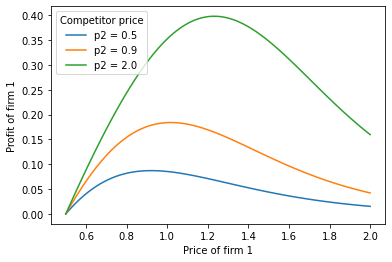

In [3]:
fig, ax = plt.subplots()
pp = np.linspace(c, 2., 100) # the grid we plot over 

for p2 in [0.5, 0.9, 2.0]: 
    ff = [profit1(p, p2) for p in pp] # loop through and evaluate profits 
    ax.plot(pp, ff, label=f'p2 = {p2}'); 
plt.xlabel('Price of firm 1'); plt.ylabel('Profit of firm 1'); 
plt.legend(title='Competitor price'); 

From the graph above, it is clear that firm 1's profit increases overall when firm 2 raises the price (because the two products are substitutes). However, the optimal price also change, although not by much. 

# Manual iterative best response

**Proposition:** The firms will always choose a price $p^i \in (c; \infty)$. 

**Proof:** Given our game setup, we know that for $p^i \le c$, we will have $\pi^i \le 0$. Similarly, due to the demand function, when $p^i \to \infty$, the market share will tend to zero, $ s^i \to 0$. However, since the profit is a product then, $\pi^i = (s^i - c)p^i$, it depends on the relative speed of $p^i \to \infty$  and $ s^i \to 0$ which one will dominate. However, it turns out that the latter dominates so that $ \pi^i \to 0$  as $p^i \to \infty$. 

**Best response:** We cannot generally solve the profit maximization problem in the same way as we did with a simple linear demand curve. However, there is nothing wrong with taking `scipy.optimize.minimize` for a spin! We just have to use the negative of profits as the objective function since it is minimizing and we want to maximize profits. The algorithm then works as follows: 
1. Initialize `p2` to some value
2. Find `p1` that minimizes `-pi(p, p2, i=0)` wrt. `p` - call the minimizer `p1`. 
3. Find `p2` that minimizes `-pi(p1, p, i=1)` wrt. `p` - call the minimizer `p2`. 
4. repeat 2-3 until nothing changes. 

**Equilibrium:** The pure strategy Nash equilibrium occurs when both firms are choosing a price that is a best response to the price of the competitor. 

In [4]:
p1 = np.array([.6]) # initial guess (as a vector (of length 1))
f_ = lambda p: -profit1(p, p2) # anonymous function of one variable
res = minimize(f_, x0=p1)
p1 = res.x[0]
p1

/Users/mrz577/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


1.2316572060225797

In [5]:
p1 = res['x'][0]
print(f'BR1(p2={p2:5.2f}) = {p1:5.2f}')

BR1(p2= 2.00) =  1.23


In [6]:
f_ = lambda p: -profit2(p, p1)
res = minimize(f_, x0=p2)
p2 = res['x'][0]
print(f'BR2(p1={p1:5.2f}) = {p2:5.2f}')

BR2(p1= 1.23) =  1.11


Now, we have taken the first two steps in the **iterated best response algorithm**. Continuing is left as an exercise to you. 

# Nash Best Response Fixed Point

One method for solving for the Nash Equilibrium is based on `fsolve`, which solves a nonlinear system of equations. In that case, the system is 
$$
\begin{align*}
BR_1(p_2)-p_1 = 0 \\
BR_2(p_1)-p_2 = 0 \\
\end{align*}
$$

This requires you to code up a vector-valued function, $BR : \mathbb{R}^2 \to \mathbb{R}^2$, e.g. `BR(p)`, and then to call 

```Python
p = fsolve(BR, p) # this may fail!
```

While this is seemingly what we want, it may fail! The reason is that we have a numerical optimizer on the outside and another numerical optimizer on the inside. Therefore, we are forced to think carefully about the optimal *step sizes*. 

**The solution:** Use a more *coarse* (i.e. larger) step size on the outside. 

```Python
p = fsolve(BR, p, epsfcn=1e-4) # this will be more robust
```

**Why?** It's because the default step size (used for numerical gradients) is chosen to work well in a "nicely behaved" setting. But if we are taking a step size of something nested that itself already has numerical error (because it also uses a step size), then the optimal choice of step size is affected. So the inner loop can use default step size, but the outer loop must account for the fact that the problem is more noisy. 

In [7]:
def BR1(p2): 
    # fill in 
    return p1

def BR2(p1): 
    # fill in 
    return p2

def BR(p): 
    p1, p2 = p # unpack 2-vector 
    # fill in 
    return p_new



In [8]:
# the fixed point mapping: if f(p) returns zeros, we have a Nash Equilibrium
f = lambda p: BR(p) - p

This calls `fsolve` without changing the step size. 

In [9]:
p0 = np.array([.5,.5])
fsolve(f, p0)

array([1.06391301, 1.06391301])

This calls `fsolve` with a larger step size

In [12]:
pNE = fsolve(f, p0, epsfcn=1e-4)
pNE

/Users/mrz577/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


array([1.06391301, 1.06391301])

And now we can plot the two best response functions together. 

/Users/mrz577/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


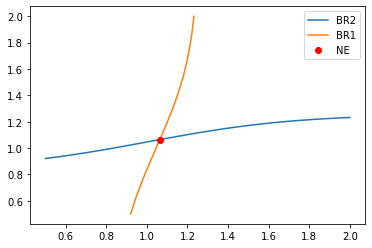

In [16]:
pp = np.linspace(c, 2., 100) # pick some price grid that makes sense...
bb1 = [BR1(p2) for p2 in pp]
bb2 = [BR2(p1) for p1 in pp]
plt.plot(pp, bb2, label=f'BR2');
plt.plot(bb1, pp, label=f'BR1');
plt.plot(pNE[0], pNE[1], 'or', label='NE');
plt.legend();